In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
def load_results(file_name):
    data = None
    with open(file_name, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

def filter_top_model_results(top_models, all_model_results):
    filtered_data = list()
    for idx, row in top_models.iterrows():
        #print("row.label: " + row.label + ',' + row.classifier + ',' + row.sampling_method)
        for res in all_model_results:       
            for alg_results in res:
                if alg_results[0] == row.label and alg_results[1] == row.classifier and alg_results[2] == row.sampling_method:
                    #print("row.label: " + row.label + ',' + row.classifier + ',' + row.sampling_method + ',' + row.exp_key)
                    filtered_data.append(("{} - {} :: {}".format(row.exp_key, row.classifier, row.sampling_method), 
                                          alg_results))
    return filtered_data

def prepare_plot_data(model_results):
    plot_data = list()
    for res in model_results:       
        for label, alg_results in res:
            _, model_name, sampling_method, _, tpr, fpr, roc_auc, precision, recall, prc_auc = alg_results

            #if 'time_budget' in top_models.columns:
            #    plot_data.append(("{} :: {}".format(exp_key + '-' + model_name + '::' + row.time_budget, sampling_method), tpr, fpr, roc_auc, precision, recall, prc_auc))
            #else:
            plot_data.append((label, tpr, fpr, roc_auc, precision, recall, prc_auc))

    return plot_data

def rebuild_results(res):
    ## Gather all the metrics
    temp_metrics = pd.DataFrame()
    temp_results = list()
    for i in range(0, len(res)):
        temp_metrics = pd.concat([temp_metrics, res[i][1]])
        temp_results.append(res[i][2]) 
    
    return temp_metrics, temp_results

In [4]:
measurements = ['exp_key', 'label', 'classifier', 'sampling_method', \
                #'fp', 'fn',\
                'balanced_accuracy', 'recall', 'precision', \
                 #'f1_score',\
                'time_budget', 'aucroc', 'auprc',\
                'model_churn_cost']

measurements_alias = ['experiment', 'label', 'classifier', 'sampling', \
                      #'fp', 'fn',\
                      'bal_acc', 'recall', 'precision',\
                      # 'f1',\
                      'time_budget', 'auroc', 'auprc',\
                      'churn_cost']

In [5]:
measure_by = ['balanced_accuracy', 'recall', 'model_churn_cost']
measure_by_sort = [False, False, True]

# measure_by = ['balanced_accuracy']
# measure_by_sort = [False]

# measure_by = ['model_churn_cost']
# measure_by_sort = [True]

# measure_by = ['f1_score']
# measure_by_sort = [False]

## Summarise performance of the best overall approaches

In [6]:
top_metrics = pd.DataFrame()
top_results = list()

experiments = {'Exp 1.1':'/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle',
               'Exp 2.1':'/home/dissertation/code/RESULTS_FINAL/Manual_GridSearch_2019-08-10.pickle',
               'Exp 2.2':'/home/dissertation/code/RESULTS_FINAL/Manual_RdmSearch_2019-08-10.pickle',
               'Exp 3.1':'/home/dissertation/code/RESULTS_FINAL/DFS_Default_2019-08-10.pickle',
               'Exp 3.2':'/home/dissertation/code/RESULTS_FINAL/DFS_RdmSearch_2019-08-18.pickle',
               'Exp 4.1':'/home/dissertation/code/RESULTS_FINAL/Basic_Asklearn_20190813.pickle',
               'Exp 4.2':'/home/dissertation/code/RESULTS_FINAL/Manual_Asklearn_20190816.pickle',
               'Exp 4.3':'/home/dissertation/code/RESULTS_FINAL/DFS_Asklearn_20190818.pickle',
              }
                      
for exp_key, exp_datafile in experiments.items():
    print(exp_key, exp_datafile)
    exp = load_results(exp_datafile)
    exp_metrics, exp_results = rebuild_results(exp)
    exp_metrics['exp_key'] = exp_key
    
    top_metrics = top_metrics.append(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1))
    
    top_results.append(filter_top_model_results(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1), exp_results))

# Convert train_time
top_metrics['train_time'] = (top_metrics['train_time']/60)
top_metrics['cv_time'] = (top_metrics['cv_time']/60)

# Convert model_churn_cost to EUR from TWD
top_metrics['model_churn_cost'] = np.round(top_metrics['model_churn_cost'] * 0.029).astype(int)
top_metrics['time_budget'] = top_metrics['train_time']
top_metrics.loc[top_metrics.classifier == 'AutoSklearnClassifier', 'time_budget'] = top_metrics[top_metrics.classifier == 'AutoSklearnClassifier'].label.str.replace('[^0-9]', '', regex=True)

top_metrics

Exp 1.1 /home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle
Exp 2.1 /home/dissertation/code/RESULTS_FINAL/Manual_GridSearch_2019-08-10.pickle
Exp 2.2 /home/dissertation/code/RESULTS_FINAL/Manual_RdmSearch_2019-08-10.pickle
Exp 3.1 /home/dissertation/code/RESULTS_FINAL/DFS_Default_2019-08-10.pickle
Exp 3.2 /home/dissertation/code/RESULTS_FINAL/DFS_RdmSearch_2019-08-18.pickle
Exp 4.1 /home/dissertation/code/RESULTS_FINAL/Basic_Asklearn_20190813.pickle
Exp 4.2 /home/dissertation/code/RESULTS_FINAL/Manual_Asklearn_20190816.pickle
Exp 4.3 /home/dissertation/code/RESULTS_FINAL/DFS_Asklearn_20190818.pickle


,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample,exp_key,time_budget
0,XGB_basic_5cv_recall,XGBClassifier,ROS 1:1,204794,6209,17852,28632,0.865,0.384,0.742,...,0.691,0.881,0.624,0.810,0.389,0.005,224834,0,Exp 1.1,2.677
0,RF_grid_5cv_recall,RandomForestClassifier,ROS 2:1,204030,6283,17778,29396,0.861,0.377,0.739,...,0.902,0.887,0.605,0.806,0.707,0.003,227908,0,Exp 2.1,100.315
0,RF_random_5cv_recall,RandomForestClassifier,ROS 2:1,199480,5681,18380,33946,0.846,0.351,0.764,...,0.704,0.886,0.600,0.809,0.740,0.010,234120,0,Exp 2.2,40.997
0,XGB_dfsbasic_5cv_recall,XGBClassifier,ROS 1:1,217765,5172,18889,15661,0.919,0.547,0.785,...,2.677,0.946,0.748,0.859,0.647,0.039,175189,0,Exp 3.1,11.267
0,RF_dfsrandom_5cv_recall,RandomForestClassifier,RUS 1:1,216325,4447,19614,17101,0.916,0.534,0.815,...,2.634,0.951,0.752,0.871,0.854,0.014,170955,0,Exp 3.2,9.356
0,ASKLEARN_15_askbasic_Nonecv_recall,AutoSklearnClassifier,RUS 1:1,198852,4833,19228,34574,0.847,0.357,0.799,...,0.000,0.898,0.645,0.826,-1,-1,226104,0,Exp 4.1,15
0,ASKLEARN_50_askbasic_Nonecv_recall,AutoSklearnClassifier,RUS 1:1,190881,4757,19304,42545,0.816,0.312,0.802,...,0.000,0.883,0.583,0.810,-1,-1,248339,0,Exp 4.2,50
0,ASKLEARN_55_askbasic_Nonecv_recall,AutoSklearnClassifier,RUS 1:1,216861,4071,19990,16565,0.920,0.547,0.831,...,0.000,0.954,0.769,0.880,-1,-1,165039,0,Exp 4.3,55


### The best/worst performing models as measured by .... 

In [41]:
### print("Getting best results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

temp = top_metrics.sort_values(measure_by, ascending=measure_by_sort)

temp = temp[measurements]
temp['classifier'] = temp['classifier'].apply(lambda v: str(v).replace('Classifier', ''))
temp.columns = measurements_alias
temp

print(temp.drop(columns=['classifier'], axis=1).to_latex(index=False))

\begin{tabular}{lllrrrlrrr}
\toprule
experiment &                               label & sampling &  bal\_acc &  recall &  precision & time\_budget &  auroc &  auprc &  churn\_cost \\
\midrule
   Exp 4.3 &  ASKLEARN\_55\_askbasic\_Nonecv\_recall &  RUS 1:1 &    0.880 &   0.831 &      0.547 &          55 &  0.954 &  0.769 &      165039 \\
   Exp 3.2 &             RF\_dfsrandom\_5cv\_recall &  RUS 1:1 &    0.871 &   0.815 &      0.534 &       9.356 &  0.951 &  0.752 &      170955 \\
   Exp 3.1 &             XGB\_dfsbasic\_5cv\_recall &  ROS 1:1 &    0.859 &   0.785 &      0.547 &      11.267 &  0.946 &  0.748 &      175189 \\
   Exp 4.1 &  ASKLEARN\_15\_askbasic\_Nonecv\_recall &  RUS 1:1 &    0.826 &   0.799 &      0.357 &          15 &  0.898 &  0.645 &      226104 \\
   Exp 4.2 &  ASKLEARN\_50\_askbasic\_Nonecv\_recall &  RUS 1:1 &    0.810 &   0.802 &      0.312 &          50 &  0.883 &  0.583 &      248339 \\
   Exp 1.1 &                XGB\_basic\_5cv\_recall &  ROS 1:1 &    0.810 &

### Summary performance statistics of classifiers over all sampling techniques

In [8]:
## Excludes LR and MLP as those produce bad classifiers

stats_summary = {'best':max,
                 'median':'median', 
                 'iqr':lambda x: np.percentile(x, 75, interpolation='higher') - np.percentile(x, 25, interpolation='lower'),
                 #'range':lambda x: max(x) - min(x)
                }
#[~exp_metrics.recall.isin([0.0, 1.0])]
summary = \
    top_metrics\
            .groupby(['exp_key'])\
            .agg({
                 'balanced_accuracy':stats_summary,
                 'recall':stats_summary,
                 'precision':stats_summary,
                 'model_churn_cost':{'best':min},
                 #'aucroc':stats_summary,
                 #'auprc':stats_summary,
                 'train_time':'median',
                 })\
            .reset_index()\
            .sort_values(('balanced_accuracy', 'best'), ascending=False)
summary
#print(summary.to_latex(index=False))

/home/anaconda/envs/py373/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


exp_key balanced_accuracy              recall              precision  \
                        best median   iqr   best median   iqr      best   
7  Exp 4.3             0.880  0.880 0.000  0.831  0.831 0.000     0.547   
4  Exp 3.2             0.871  0.871 0.000  0.815  0.815 0.000     0.534   
3  Exp 3.1             0.859  0.859 0.000  0.785  0.785 0.000     0.547   
5  Exp 4.1             0.826  0.826 0.000  0.799  0.799 0.000     0.357   
6  Exp 4.2             0.810  0.810 0.000  0.802  0.802 0.000     0.312   
0  Exp 1.1             0.810  0.810 0.000  0.742  0.742 0.000     0.384   
2  Exp 2.2             0.809  0.809 0.000  0.764  0.764 0.000     0.351   
1  Exp 2.1             0.806  0.806 0.000  0.739  0.739 0.000     0.377   

               model_churn_cost train_time  
  median   iqr             best     median  
7  0.547 0.000           165039     64.786  
4  0.534 0.000           170955      9.356  
3  0.547 0.000           175189     11.267  
5  0.357 0.000           226104     20.683  
6  0.312 0.000           248339     58.546  
0  0.384 0.000           224834      2.677  
2  0.351 0.000           234120     40.997  
1  0.377 0.000           227908    100.315

### The best performing models by sampling method as measured by .... 

In [ ]:
# print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))
# # top_results = exp_metrics[(exp_metrics.recall > 0) & (exp_metrics.recall < 1)]\
#                     .sort_values(measure_by, ascending=measure_by_sort).groupby('sampling_method').head(1)
# top_results = top_results[measurements]
# top_results.sort_values('balanced_accuracy', ascending=False)

### Classifier train time distribution by sampling method

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.ylabel('Seconds')
top_metrics.boxplot(column='train_time', by='sampling_method', ax=ax)
plt.title('Classifier Training Time Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Sampling Method')

### Recall/Bal Acc performance over time_budgets or sampling_method

Text(0.5, 0.98, 'Classifier Performance Distribution\n')

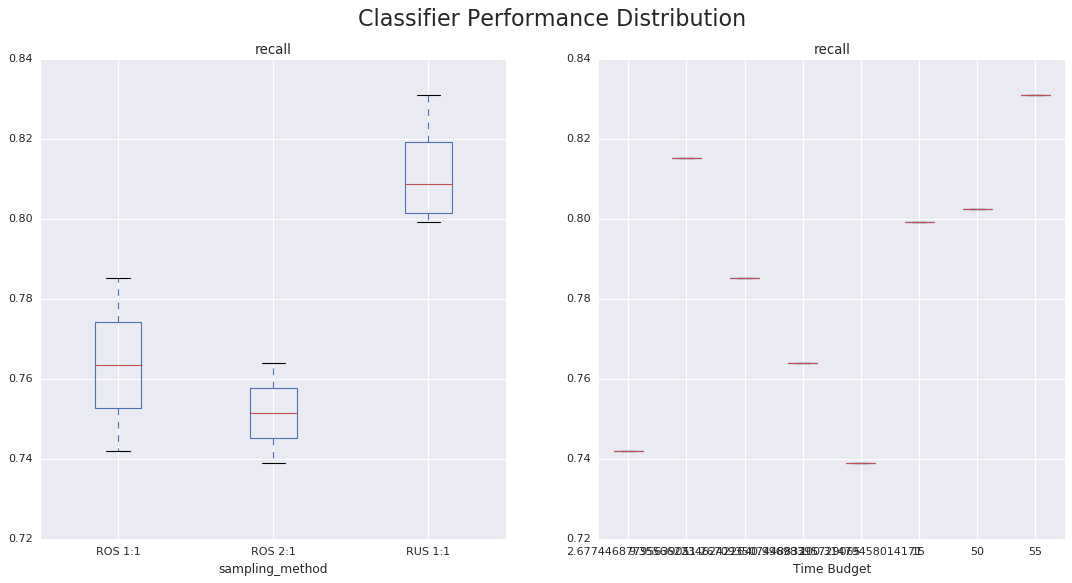

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

top_metrics.boxplot(column='recall', by='sampling_method', ax=axes[0])
plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Sampling Method')


top_metrics.boxplot(column='recall', by='time_budget', ax=axes[1])
plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Time Budget')

fig = axes[1].get_figure()
fig.suptitle('Classifier Performance Distribution\n', size=20)

Text(0.5, 0.98, 'Classifier Performance Distribution - Recall\n')

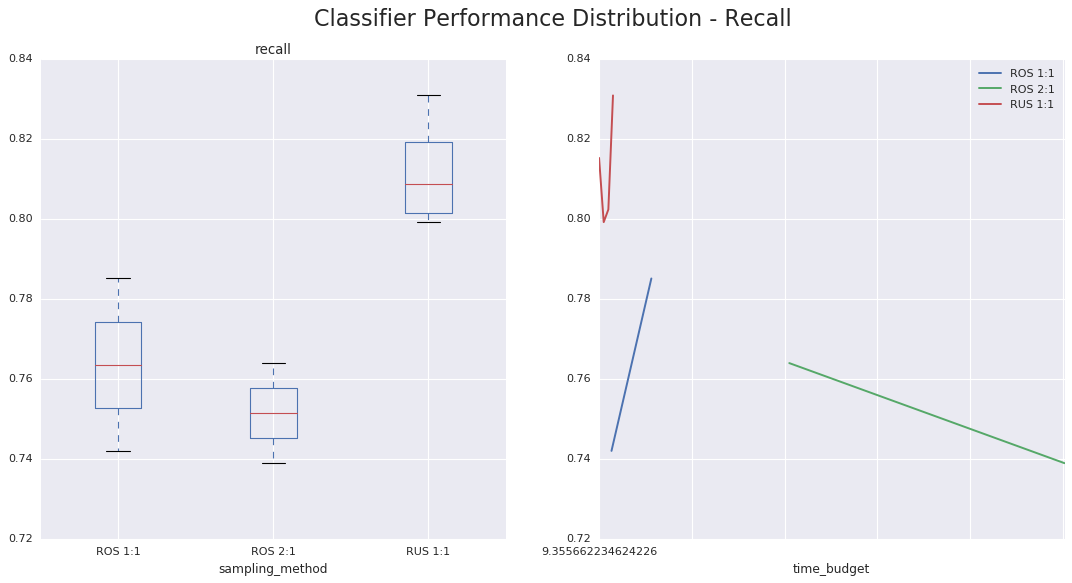

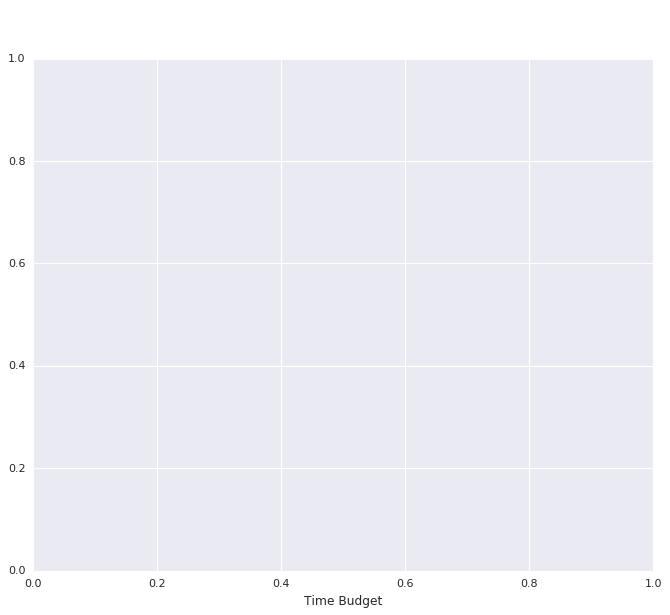

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

top_metrics.boxplot(column='recall', by='sampling_method', ax=axes[0])
plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Sampling Method')

## Plot the balanced_accuracy over time grouped by sampling_method
df = top_metrics.copy(deep=True)
fig, ax = plt.subplots(figsize=(10,8))
df.set_index('time_budget', inplace=True)
df.groupby('sampling_method')['recall'].plot(legend=True, ax=axes[1])
plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Time Budget')

fig = axes[0].get_figure()
fig.suptitle('Classifier Performance Distribution - Recall\n', size=20)

### For this approach plot the best models by classifier

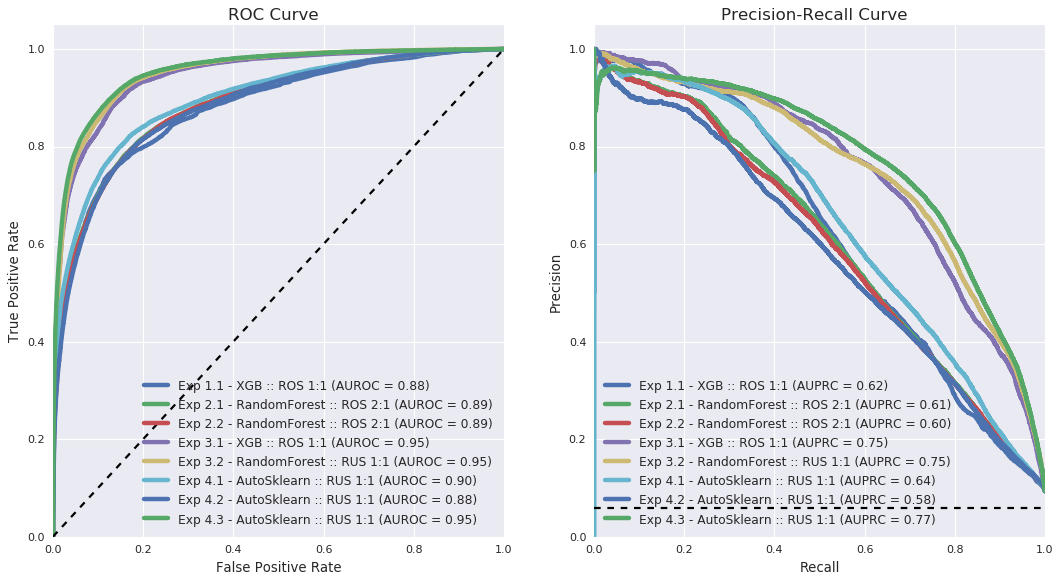

In [36]:
#print("Getting best results by classifier based on {} / ordered ascending? {}".format(measure_by, measure_by_sort))

#temp_metrics = temp = top_metrics.sort_values(measure_by, ascending=measure_by_sort).copy()
#plot_results = temp_metrics.sort_values(measure_by, ascending=measure_by_sort)

style.use('seaborn')

plot_data = prepare_plot_data(top_results)

plot_roc_prc(plot_data, ' ')

### Choosing the best model and appending to overall .... 

In [ ]:
top_models

In [ ]:
top_results

In [ ]:
top_models

In [ ]:
from scipy import stats
import scikit_posthocs as sp

xgb = plot_data[0][-2]
rf = plot_data[1][-2]
dt = plot_data[2][-2]
gnb = plot_data[3][-2]
lr = plot_data[4][-2]
mlp = plot_data[5][-2]

data = [xgb, rf, dt, gnb, lr, mlp]

stats.kruskal(*data)

In [ ]:
sp.posthoc_conover(data)

In [ ]:
#all_metrics[all_metrics.recall < 1.0].sort_values(['recall'], ascending=[False])

In [ ]:
#all_metrics.sort_values(['recall','precision'], ascending=[False, False])

In [ ]:
print(top_results.to_latex(index=False)) # doctest: +NORMALIZE_WHITESPACE

In [ ]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import statsmodels.formula.api as sfa

df = sa.datasets.get_rdataset('iris').data
data = [df.loc[ids, 'Sepal.Width'].values for ids in df.groupby('Species').groups.values()]

In [ ]:
H, p = ss.kruskal(*data)
print(H, p)

In [ ]:
sp.posthoc_conover(df, val_col='Sepal.Width', group_col='Species', p_adjust = 'holm')

In [ ]:
df.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

In [ ]:
lm = sfa.ols('Sepal_Width ~ C(Species)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
sp.posthoc_ttest(df, val_col='Sepal_Width', group_col='Species', p_adjust='holm')